sum_CS_10D
mean value: 3.9682105966371894 STD value: 1.9111803410202866
sum_CsCh
mean value: 6.879721004739266 STD value: 1.5915524795465144
sum_Cs_5DIZ
mean value: 5.937377640867567 STD value: 1.8215906559619304
sum_LDA_5DIZ
mean value: 7.1426858234786055 STD value: 2.362980279905224
sum_OCT_5DIZ
mean value: 5.995283046618708 STD value: 2.742016850779643
sum_LDA_OCT_5DIZ
mean value: 6.784484990750287 STD value: 3.1838125675393343


F_onewayResult(statistic=60.13919710353523, pvalue=3.4407986405748343e-57)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
      CS_10D         CsCh   2.9115    0.0  2.3175  3.5055   True
      CS_10D      Cs_5DIZ   1.9692    0.0  1.3554   2.583   True
      CS_10D     LDA_5DIZ   3.1745    0.0  2.5861  3.7628   True
      CS_10D LDA_OCT_5DIZ   2.8163    0.0  2.2025  3.4301   True
      CS_10D     OCT_5DIZ   2.027

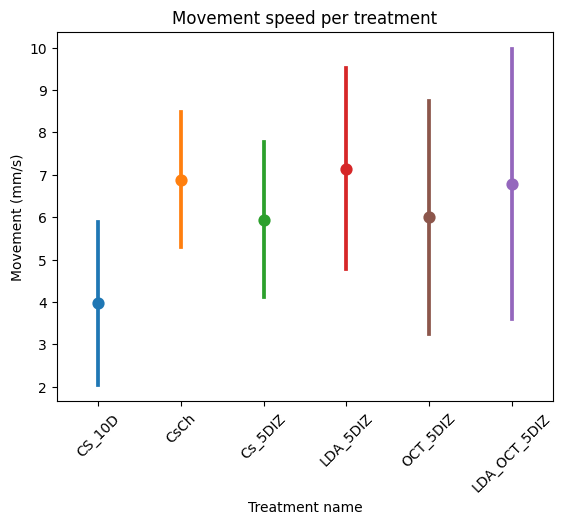

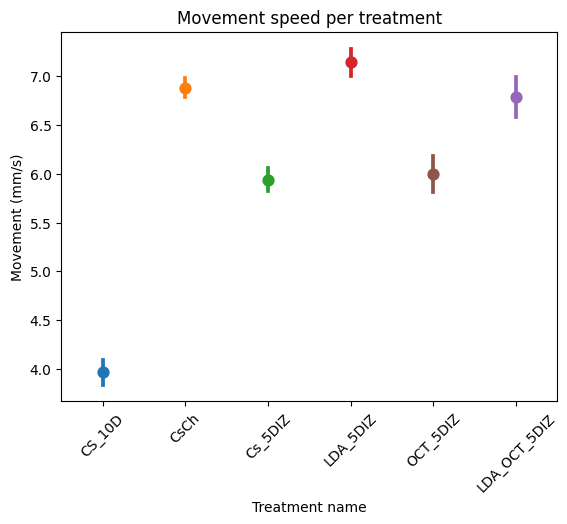

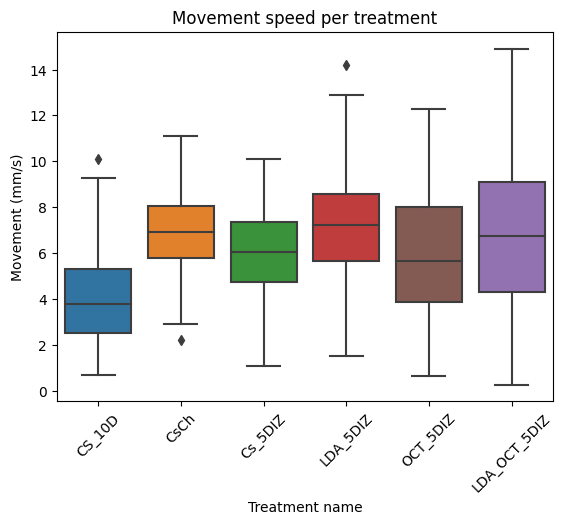

In [4]:
import os
import toml
import scipy.stats

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
    
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")

all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    group_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Snapshot'] = (df.index / config["FPS"] / config["TIME_WINDOW"]).astype(int) + 1
        df['Group'] = group_name.replace(".csv","")
        group_dataframes.append(df)

    df = pd.concat(group_dataframes)
    df.set_index('Snapshot', inplace=True)
    df.set_index('Group', append=True, inplace=True)
    df['Treatment'] = treatment_name
    df.set_index('Treatment', append=True, inplace=True)
    df = df.reorder_levels(['Treatment', 'Group', 'Snapshot'])
  
    treatment_dataframes.append(df)
    
combined_data = pd.concat(treatment_dataframes)
combined_data_reset = combined_data.groupby(['Treatment', 'Group']).sum()
combined_data_reset = combined_data_reset.stack().reset_index().rename(columns={'level_2': 'Fly', 0: 'Distance'})
combined_data_reset['Distance'] = combined_data_reset['Distance'] / config['EXPERIMENT_DURATION']

treatment_sums = {}
for treatment in config["TREATMENTS"]:
    treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']

for treatment in treatment_sums.keys():
    print(f"{treatment}")
    print(f"mean value: {np.mean(treatment_sums[treatment])} STD value: {np.std(treatment_sums[treatment])}")

anova_result = scipy.stats.f_oneway(*treatment_sums.values())
print("\n")
print(f'{anova_result}')

all_data = np.concatenate([*treatment_sums.values()])
group_labels = []
for treatment in config["TREATMENTS"]:
    group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment]['Distance']))

tukey_results = pairwise_tukeyhsd(all_data, group_labels)
print('='*64)
print(tukey_results)

sns.pointplot(data=combined_data_reset, x='Treatment', y='Distance', hue='Treatment', errorbar="sd",
              dodge=False, order=config["TREATMENTS"])
plt.title('Movement speed per treatment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")
plt.xlabel("Treatment name")
plt.ylabel("Movement (mm/s)")
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()

sns.pointplot(data=combined_data_reset, x='Treatment', y='Distance', hue='Treatment', errorbar="se",
              dodge=False, order=config["TREATMENTS"])
plt.title('Movement speed per treatment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")
plt.xlabel("Treatment name")
plt.ylabel("Movement (mm/s)")
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()

sns.boxplot(data=combined_data_reset, x='Treatment', y='Distance', hue='Treatment', dodge=False, order=config["TREATMENTS"])
plt.title('Movement speed per treatment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Treatment")
plt.xlabel("Treatment name")
plt.ylabel("Movement (mm/s)")
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()